In [ ]:
Predicting players rating
In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.

In [ ]:
Import Libraries

In [2]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
Read Data from the Database into pandas

In [6]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [7]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
df.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [8]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [12]:
target = df.pop('overall_rating')

In [13]:
df.shape

(183978, 41)

In [13]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

In [ ]:
Imputing target funtion :

In [14]:
target.isnull().values.sum()

836

In [ ]:
there are 836 missing value present in target function.

In [15]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


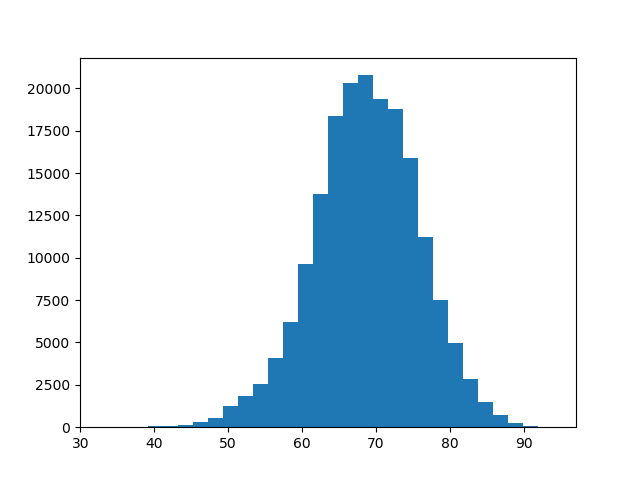

C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [16]:
plt.hist(target, 30, range=(33, 94))

In [ ]:
almost normal distribution so we can impute mean value for missing value in target.

In [17]:
y = target.fillna(target.mean())
y.isnull().values.any()

False

In [18]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

In [ ]:
we can see only four features have the type 'object'. 
here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding 
on the rest of 3 features

In [19]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
X = dummy_df.drop(['id', 'date'], axis=1)

In [ ]:
Feature selection :

    As tree model doesn't gets affected by missing values present in data set. 
    but feature selection by SelectFromModel can not be done on datasets that carries null value. 
    Therefore, we should also perform imputation on dataset.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [23]:
#finding feature_importance for feature selection. from it we'll be able to decide threshold value
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.01714286 0.02       0.10714286 0.02       0.04714286 0.03571429
 0.03285714 0.         0.04       0.         0.         0.00714286
 0.04714286 0.01       0.01571429 0.00142857 0.18571429 0.
 0.01428571 0.00571429 0.00857143 0.03142857 0.00571429 0.00714286
 0.01857143 0.01857143 0.00571429 0.         0.04285714 0.04571429
 0.01       0.04571429 0.02571429 0.02428572 0.06       0.04285714
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [24]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [25]:
select_X_train.shape

(137983, 24)

In [ ]:
Training different models :
1. Linear Regression :

In [26]:
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [27]:
grid.fit(select_X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
grid.best_params_

{'linearregression__n_jobs': -1}

In [29]:
lin_reg = pickle.dumps(grid)

In [ ]:
2. Decision Tree :

In [30]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [31]:
grid.fit(select_X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
grid.best_params_

{'decisiontreeregressor__max_depth': 13}

In [ ]:
Dectree_reg = pickle.dumps(grid)

In [ ]:
3. Ranom Forest :

In [36]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestRegressor(n_estimators=500, random_state=123))

cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'randomforestregressor__max_features':['sqrt', 'log2', 10],
              'randomforestregressor__max_depth':[9, 11, 13]}                 

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [37]:
grid.fit(select_X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...imators=500, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['sqrt', 'log2', 10], 'randomforestregressor__max_depth': [9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
grid.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 10}

In [39]:
Randfor_reg = pickle.dumps(grid)

In [ ]:
4. Xgboost regressor :

In [41]:
pipe = make_pipeline(StandardScaler(),
                     XGBRegressor(n_estimators= 500, random_state=42))

cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'xgbregressor__max_depth': [5, 7],
              'xgbregressor__learning_rate': [0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs= -1)

In [ ]:
grid.fit(select_X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
xgbreg = pickle.dumps(grid)

In [ ]:
lin_reg = pickle.loads(lin_reg)
Dectree_reg = pickle.loads(Dectree_reg)
Randfor_reg = pickle.loads(Randfor_reg)
xgbreg = pickle.loads(xgbreg)

In [ ]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=lin_reg.score(select_X_test, y_test),
                                                       Dec=Dectree_reg.score(select_X_test, y_test),
                                                       ran=Randfor_reg.score(select_X_test, y_test),
                                                       xgb=xgbreg.score(select_X_test, y_test)))

In [ ]:
By accuracy comparision performed above we can say hear that XGBoost regressor gives better result than any other model 
and it can predict the target function with approx 98% accuracy.